This python notebook is developed for analysing the impact of ChatGPT on Stackoverflow engagement - questions and answers

Import required main dependencies

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
import string
from sklearn.decomposition import TruncatedSVD

Data Load and exploration

In [44]:
df = pd.read_csv('stackoverflow.csv', usecols=range(1, 26))

In [45]:
# shape of the data
df.shape

(580466, 25)

In [46]:
# column names and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580466 entries, 0 to 580465
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   tags                   580466 non-null  object 
 1   owner                  580466 non-null  object 
 2   is_answered            580466 non-null  bool   
 3   view_count             580466 non-null  int64  
 4   answer_count           580466 non-null  int64  
 5   score                  580466 non-null  int64  
 6   last_activity_date     580466 non-null  int64  
 7   creation_date          580466 non-null  float64
 8   question_id            580466 non-null  int64  
 9   content_license        545890 non-null  object 
 10  link                   580466 non-null  object 
 11  title                  580466 non-null  object 
 12  accepted_answer_id     218130 non-null  float64
 13  last_edit_date         307475 non-null  float64
 14  closed_date            34764 non-nul

In [47]:
# sample data
df.head()

,tags,owner,is_answered,view_count,answer_count,score,last_activity_date,creation_date,question_id,content_license,...,closed_reason,migrated_from,bounty_amount,bounty_closes_date,locked_date,posted_by_collectives,protected_date,community_owned_date,new_data,final_date
0,"['python', 'instagram', 'instagrapi']","{'account_id': 29754614, 'reputation': 1, 'use...",False,36,0,0,1711929003,1.711929e+09,78253160,CC BY-SA 4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-31 23:50:03,2024-03-31
1,"['python', 'mysql', 'tkinter', 'customtkinter']","{'account_id': 30776658, 'reputation': 23, 'us...",False,83,1,0,1711956288,1.711929e+09,78253151,CC BY-SA 4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-31 23:46:07,2024-03-31
2,"['python-3.x', 'sqlalchemy']","{'account_id': 966924, 'reputation': 1487, 'us...",False,28,0,1,1711928762,1.711929e+09,78253150,CC BY-SA 4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-31 23:46:02,2024-03-31
3,"['python', 'geopandas']","{'account_id': 24127282, 'reputation': 3, 'use...",False,36,1,0,1711937874,1.711928e+09,78253122,CC BY-SA 4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-31 23:28:31,2024-03-31
4,"['java', 'android']","{'account_id': 103637, 'reputation': 10294, 'u...",True,40,1,0,1711958224,1.711927e+09,78253111,CC BY-SA 4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-31 23:21:44,2024-03-31


Remove Duplicates

In [48]:
df.drop_duplicates(inplace=True)

In [49]:
df['question_id'].value_counts()

question_id
76083052    2
74002514    2
76999084    2
77038197    2
78078945    2
           ..
75372989    1
75372995    1
75372996    1
75373002    1
69791482    1
Name: count, Length: 580328, dtype: int64

In [50]:
# Sort DataFrame by content_license
df_sorted = df.sort_values(by='content_license', ascending=True)

# Remove duplicates based on question_id, keeping the first occurrence and copy to df_unique dataframe
df_unique = df_sorted.drop_duplicates(subset='question_id', keep='first')

In [51]:
# change the data type of final_date to datetime
df_unique['final_date'] = pd.to_datetime(df_unique['final_date'], format='%Y-%m-%d')

<ipython-input-51-9f3465401ab3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['final_date'] = pd.to_datetime(df_unique['final_date'], format='%Y-%m-%d')


In [52]:
# check the datatypes and column names of df_unique dataframe which will be used for next steps
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 580328 entries, 0 to 580451
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   tags                   580328 non-null  object        
 1   owner                  580328 non-null  object        
 2   is_answered            580328 non-null  bool          
 3   view_count             580328 non-null  int64         
 4   answer_count           580328 non-null  int64         
 5   score                  580328 non-null  int64         
 6   last_activity_date     580328 non-null  int64         
 7   creation_date          580328 non-null  float64       
 8   question_id            580328 non-null  int64         
 9   content_license        545761 non-null  object        
 10  link                   580328 non-null  object        
 11  title                  580328 non-null  object        
 12  accepted_answer_id     218094 non-null  float64  

# Analysis

* This data has information on questions posted for tags python and java.

* Initially analysing the overall (considering python and java questions) trend.

Overall questions trend

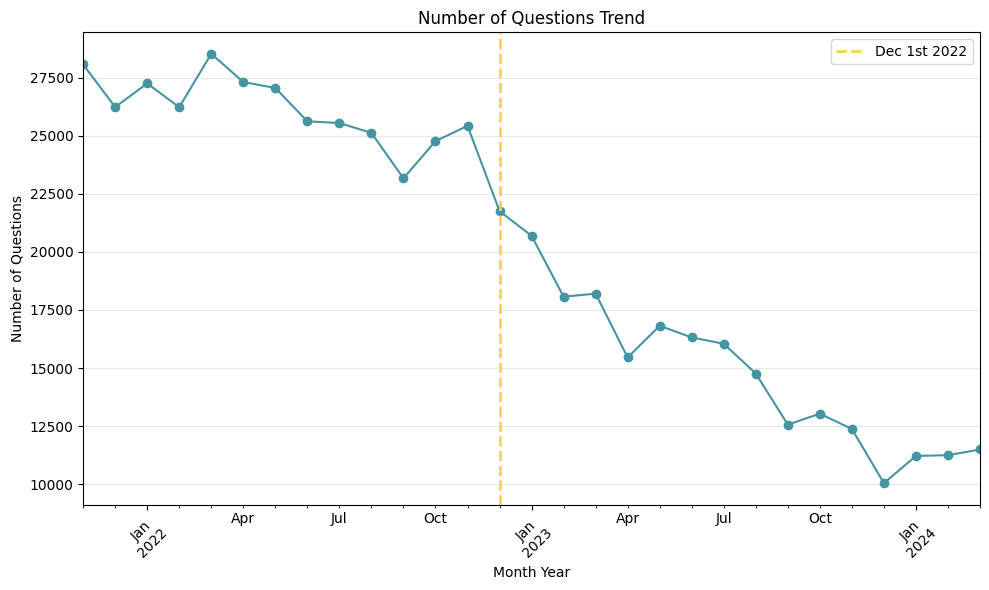

In [53]:
# Group by month and year, and count the number of questions in each group
question_trend = df_unique.groupby(df_unique['final_date'].dt.to_period('M'))['question_id'].nunique()

# Plot the trend
plt.figure(figsize=(10, 6))
question_trend.plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')  # Exclude from legend

# Add a vertical dotted line at Dec 1st 2022 with a specific HEX color and include it in the legend
plt.axvline(pd.Timestamp('2022-12-01'), color='#f9d448', linestyle='--', linewidth=2, label='Dec 1st 2022')

# Set labels and title
plt.xlabel('Month Year')
plt.ylabel('Number of Questions')
plt.title('Number of Questions Trend')

# Format x-axis tick labels
plt.xticks(rotation=45)

# Adjust the grid
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)

# Show only the vertical line in the legend
plt.legend()

# Use tight layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()

Overall average answers per question trend

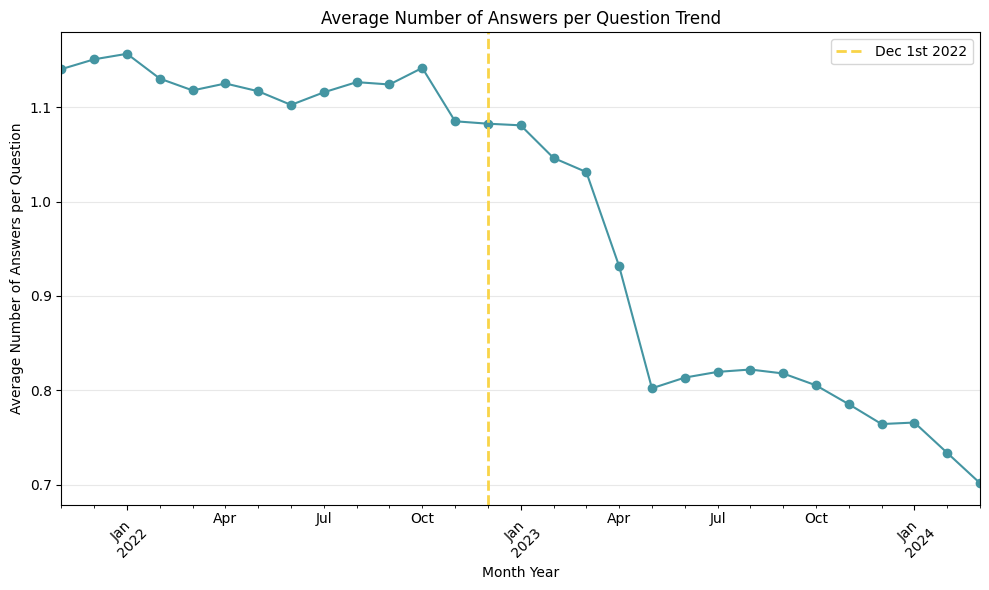

In [54]:
# Group by month and year, and calculate the total answers and number of questions per month
monthly_data = df_unique.groupby(df_unique['final_date'].dt.to_period('M')).agg(
    total_answers=('answer_count', 'sum'),
    num_questions=('question_id', 'count')
)

# Calculate average answers per question for each month
monthly_data['avg_answers_per_question'] = monthly_data['total_answers'] / monthly_data['num_questions']

# Plot the trend
plt.figure(figsize=(10, 6))
monthly_data['avg_answers_per_question'].plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')  # Adjust line color using HEX

# Add a vertical dotted line at Dec 1st 2022 with a specific HEX color and include it in the legend
plt.axvline(pd.Timestamp('2022-12-01'), color='#f9d448', linestyle='--', linewidth=2, label='Dec 1st 2022')

# Set labels and title
plt.xlabel('Month Year')
plt.ylabel('Average Number of Answers per Question')
plt.title('Average Number of Answers per Question Trend')

# Format x-axis tick labels
plt.xticks(rotation=45)

# Adjust the grid
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)

# Show only the vertical line in the legend
plt.legend()

# Use tight layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()

Overall questions with zero answers

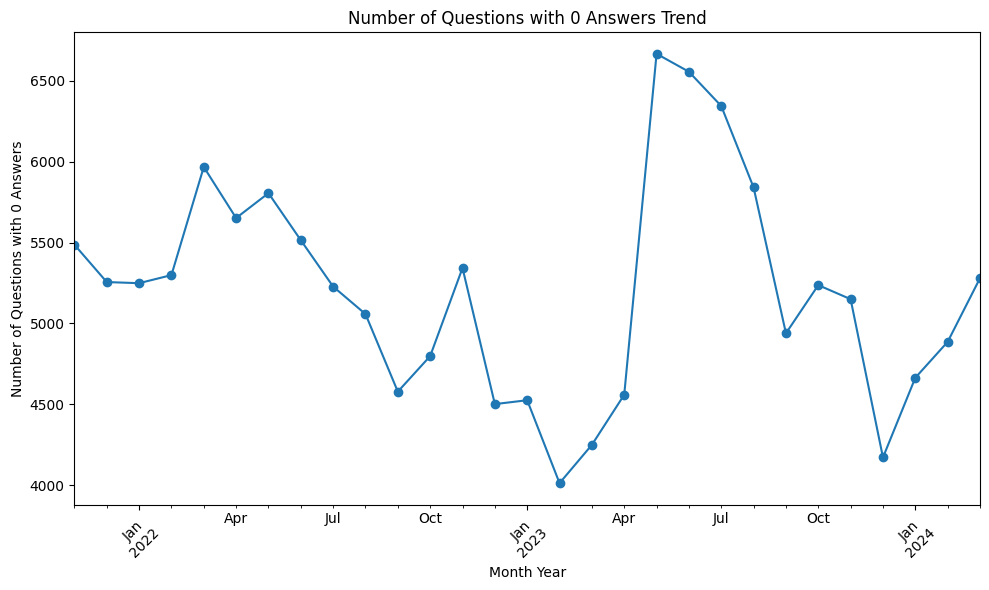

In [55]:
# Filter rows where answer_count is 0
questions_with_zero_answers = df_unique[df_unique['answer_count'] == 0]

# Group by month and year, and count the number of questions for each group
zero_answer_trend = questions_with_zero_answers.groupby(questions_with_zero_answers['final_date'].dt.to_period('M')).size()

# Plot the trend
zero_answer_trend.plot(kind='line', marker='o', figsize=(10, 6))

# Set labels and title
plt.xlabel('Month Year')
plt.ylabel('Number of Questions with 0 Answers')
plt.title('Number of Questions with 0 Answers Trend')

# Format x-axis tick labels
plt.xticks(rotation=45)

# Show plot without grid lines
plt.grid(False)

# Show plot
plt.tight_layout()
plt.show()

Overall unanswered questions percentage

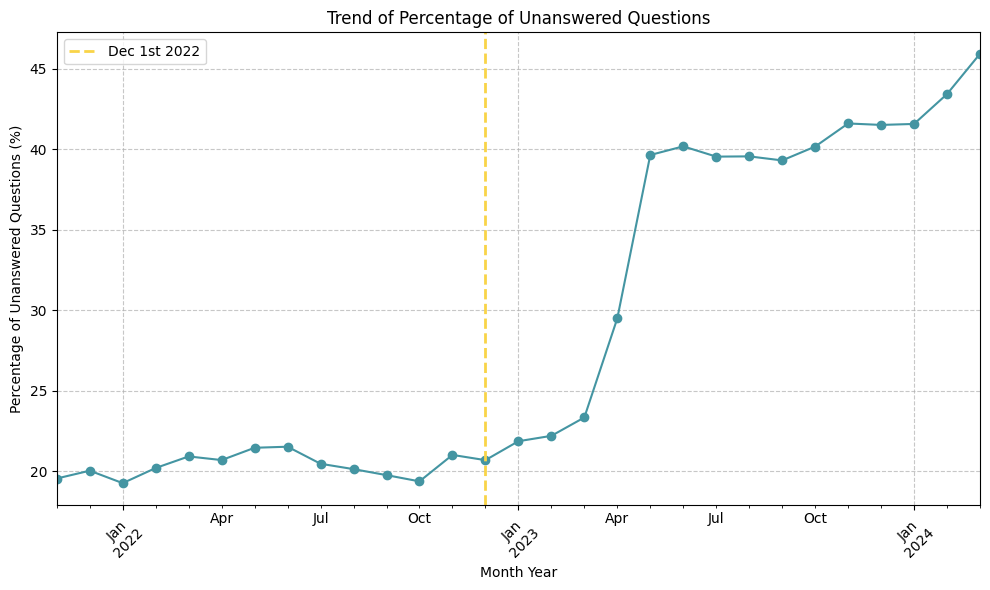

In [56]:
# Group by month and calculate total questions and unanswered questions
monthly_data = df_unique.groupby(df_unique['final_date'].dt.to_period('M')).agg(
    total_questions=('question_id', 'count'),
    unanswered_questions=('answer_count', lambda x: (x == 0).sum())
)

# Calculate the percentage of unanswered questions
monthly_data['percentage_unanswered'] = (monthly_data['unanswered_questions'] / monthly_data['total_questions']) * 100

# Plotting the trend of percentage of unanswered questions
plt.figure(figsize=(10, 6))
monthly_data['percentage_unanswered'].plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')  # Adjust line color

# Add a vertical dotted line at Dec 1st 2022 with a specific HEX color and include it in the legend
plt.axvline(pd.Timestamp('2022-12-01'), color='#f9d448', linestyle='--', linewidth=2, label='Dec 1st 2022')

# Set labels and title
plt.title('Trend of Percentage of Unanswered Questions')
plt.xlabel('Month Year')
plt.ylabel('Percentage of Unanswered Questions (%)')
plt.xticks(rotation=45)

# Adjust the grid
plt.grid(True, linestyle='--', alpha=0.7)  # Adding grid for better readability

# Show only the vertical line in the legend
plt.legend()

# Use tight layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()

Overall average score per question trend

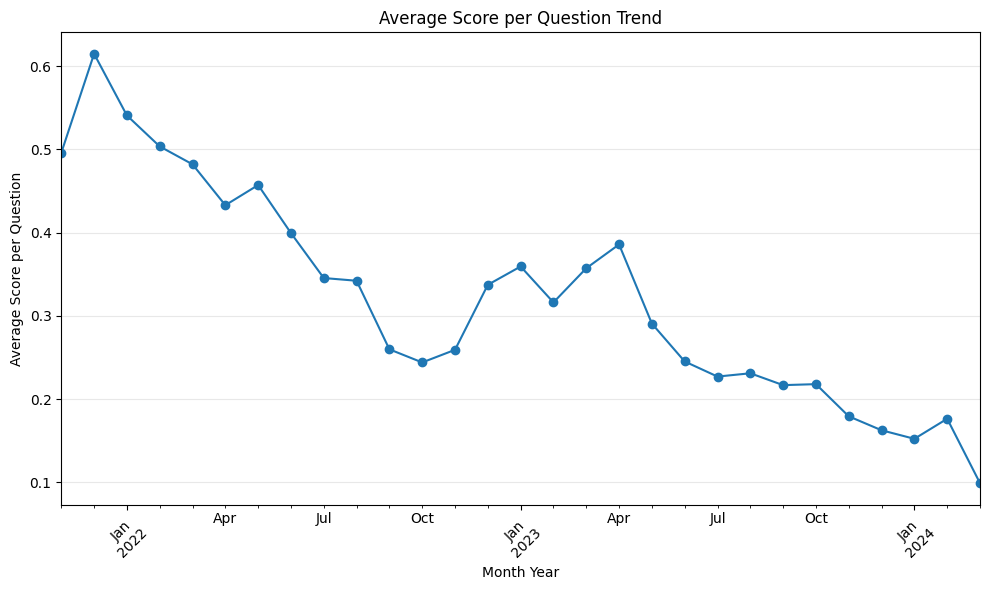

In [57]:
# Group by month and year, and calculate the total answers and number of questions per month
monthly_data = df_unique.groupby(df_unique['final_date'].dt.to_period('M')).agg(
    total_score=('score', 'sum'),
    num_questions=('question_id', 'count')
)

# Calculate average answers per question for each month
monthly_data['avg_score_per_question'] = monthly_data['total_score'] / monthly_data['num_questions']

# Plot the trend
monthly_data['avg_score_per_question'].plot(kind='line', marker='o', figsize=(10, 6))

# Set labels and title
plt.xlabel('Month Year')
plt.ylabel('Average Score per Question')
plt.title('Average Score per Question Trend')

# Format x-axis tick labels
plt.xticks(rotation=45)

# Show plot without grid lines
plt.grid(True, which='major', axis='y', color = 'lightgrey', alpha = 0.5)

# Show plot
plt.tight_layout()
plt.show()

Now, analysing the data at each tag level separately - python and java

In [58]:
# Filter for rows where the 'tags' column contains 'python' and 'java'
python_questions = df_unique[df_unique['tags'].apply(lambda tags: 'python' in tags)]
java_questions = df_unique[df_unique['tags'].apply(lambda tags: 'java' in tags)]

## Python

* Trend of python questions
* Trend of average answer per question
* Trend of percentage of unanswered questions
* Trend of average score per question

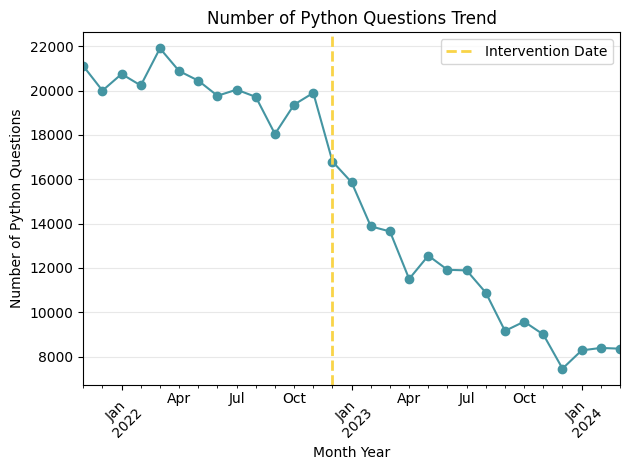

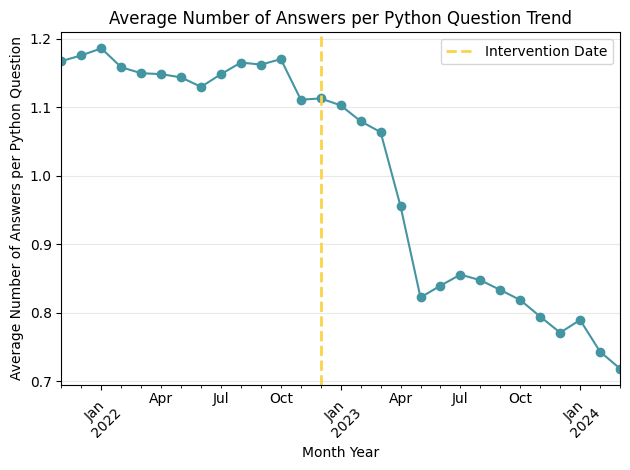

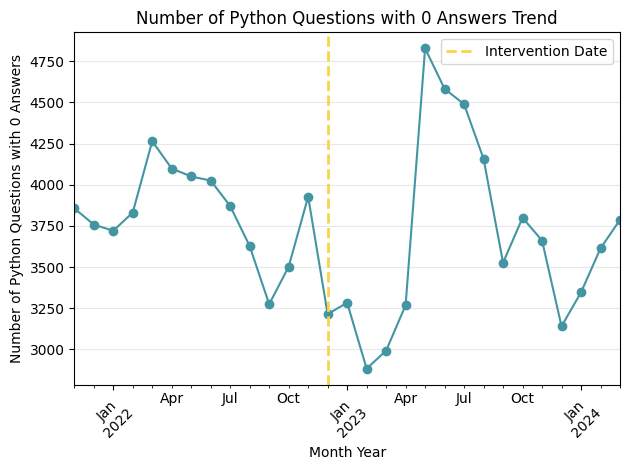

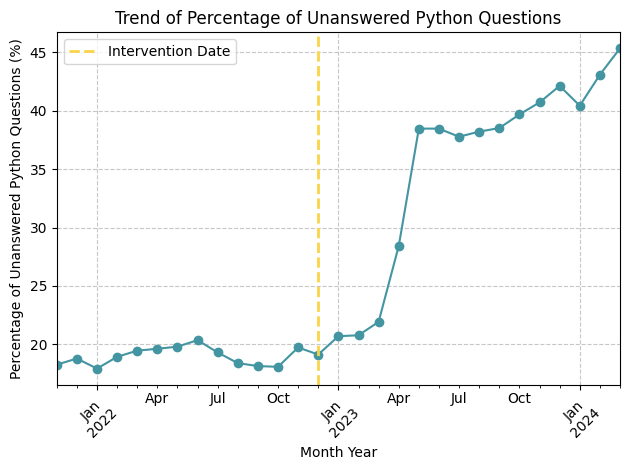

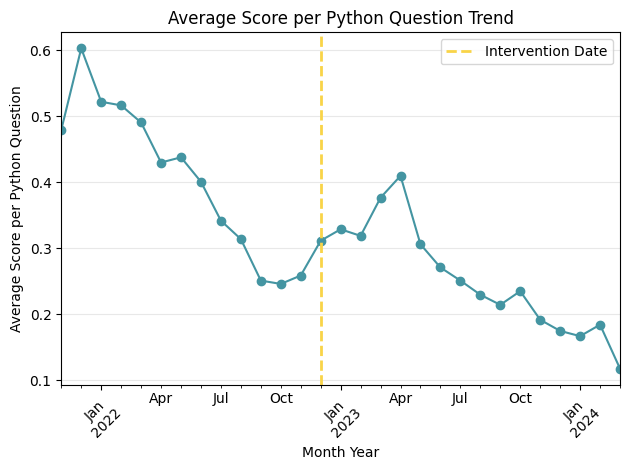

In [59]:
# Define the intervention date for the vertical line
intervention_date = pd.Timestamp('2022-12-01')

# Group by month and year, and count the number of questions
python_question_trend = python_questions.groupby(python_questions['final_date'].dt.to_period('M'))['question_id'].nunique()

# Plotting total Python questions per month
python_question_trend.plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2, label='Intervention Date')
plt.xlabel('Month Year')
plt.ylabel('Number of Python Questions')
plt.title('Number of Python Questions Trend')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the total answers and number of questions per month for Python-tagged questions
python_monthly_data = python_questions.groupby(python_questions['final_date'].dt.to_period('M')).agg(
    total_answers=('answer_count', 'sum'),
    num_questions=('question_id', 'count')
)

# Calculate average answers per question for each month
python_monthly_data['avg_answers_per_question'] = python_monthly_data['total_answers'] / python_monthly_data['num_questions']

# Plotting average number of answers per Python question per month
python_monthly_data['avg_answers_per_question'].plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2, label='Intervention Date')
plt.xlabel('Month Year')
plt.ylabel('Average Number of Answers per Python Question')
plt.title('Average Number of Answers per Python Question Trend')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Filter Python questions with zero answers
python_zero_answers = python_questions[python_questions['answer_count'] == 0]

# Count the number of Python questions with zero answers per month
python_zero_answer_trend = python_zero_answers.groupby(python_zero_answers['final_date'].dt.to_period('M')).size()

# Plotting trend of Python questions with zero answers per month
python_zero_answer_trend.plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2, label='Intervention Date')
plt.xlabel('Month Year')
plt.ylabel('Number of Python Questions with 0 Answers')
plt.title('Number of Python Questions with 0 Answers Trend')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# Group by month to calculate total Python questions and unanswered Python questions
python_monthly_data = python_questions.groupby(python_questions['final_date'].dt.to_period('M')).agg(
    total_python_questions=('question_id', 'count'),
    unanswered_python_questions=('answer_count', lambda x: (x == 0).sum())
)

# Calculate the percentage of unanswered Python questions
python_monthly_data['percentage_unanswered'] = (python_monthly_data['unanswered_python_questions'] / python_monthly_data['total_python_questions']) * 100

# Plotting trend of percentage of unanswered Python questions
python_monthly_data['percentage_unanswered'].plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2, label='Intervention Date')
plt.xlabel('Month Year')
plt.ylabel('Percentage of Unanswered Python Questions (%)')
plt.title('Trend of Percentage of Unanswered Python Questions')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Group by month and year, and calculate the total scores and number of questions per month
python_monthly_scores = python_questions.groupby(python_questions['final_date'].dt.to_period('M')).agg(
    total_score=('score', 'sum'),
    num_questions=('question_id', 'count')
)

# Calculate average score per question for each month
python_monthly_scores['avg_score_per_question'] = python_monthly_scores['total_score'] / python_monthly_scores['num_questions']

# Plotting average score per Python question per month
python_monthly_scores['avg_score_per_question'].plot(kind='line', marker='o', linestyle='-', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2, label='Intervention Date')
plt.xlabel('Month Year')
plt.ylabel('Average Score per Python Question')
plt.title('Average Score per Python Question Trend')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Java

* Trend of python questions
* Trend of average answer per question
* Trend of percentage of unanswered questions
* Trend of average score per question

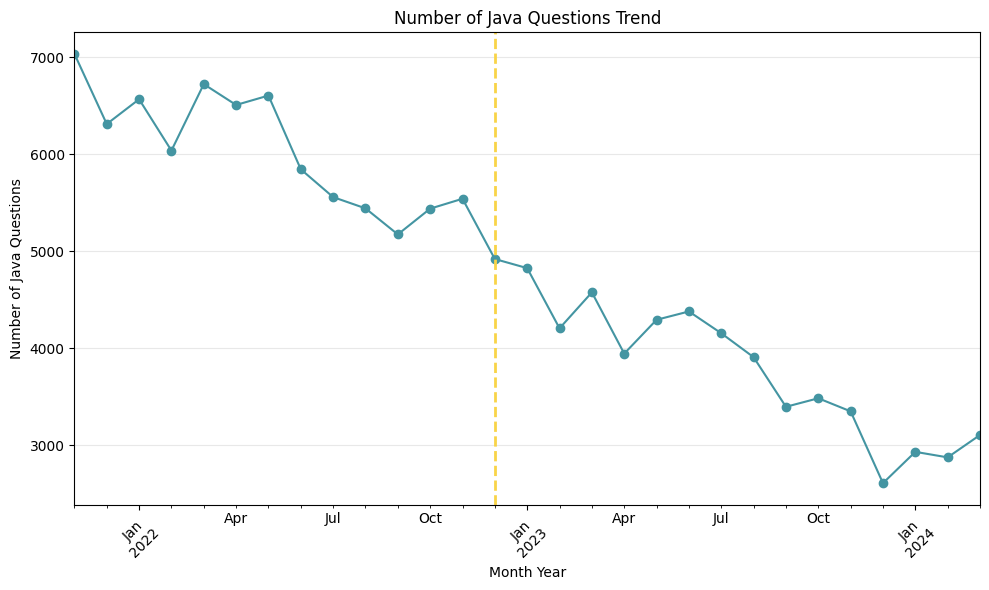

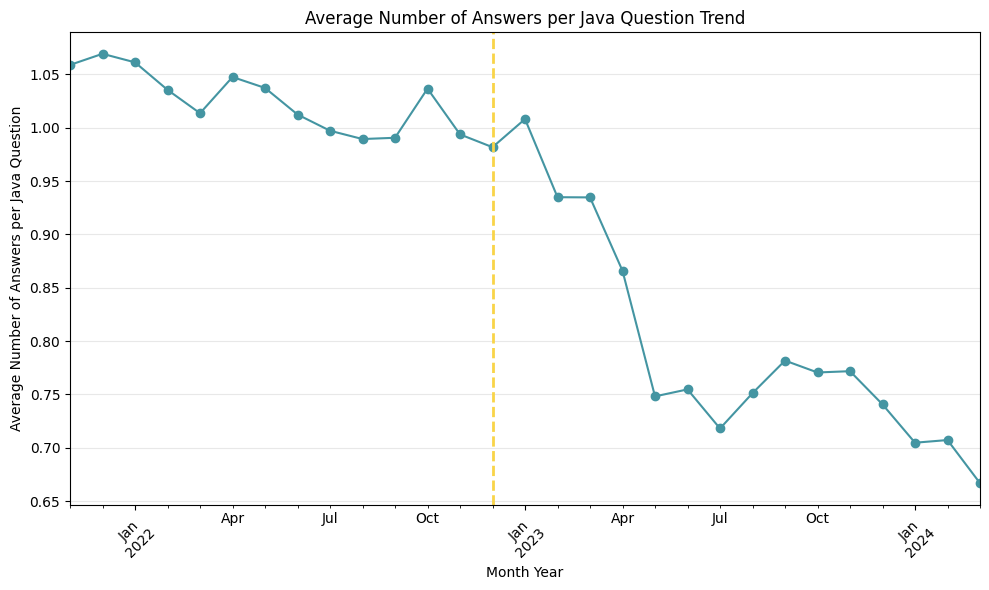

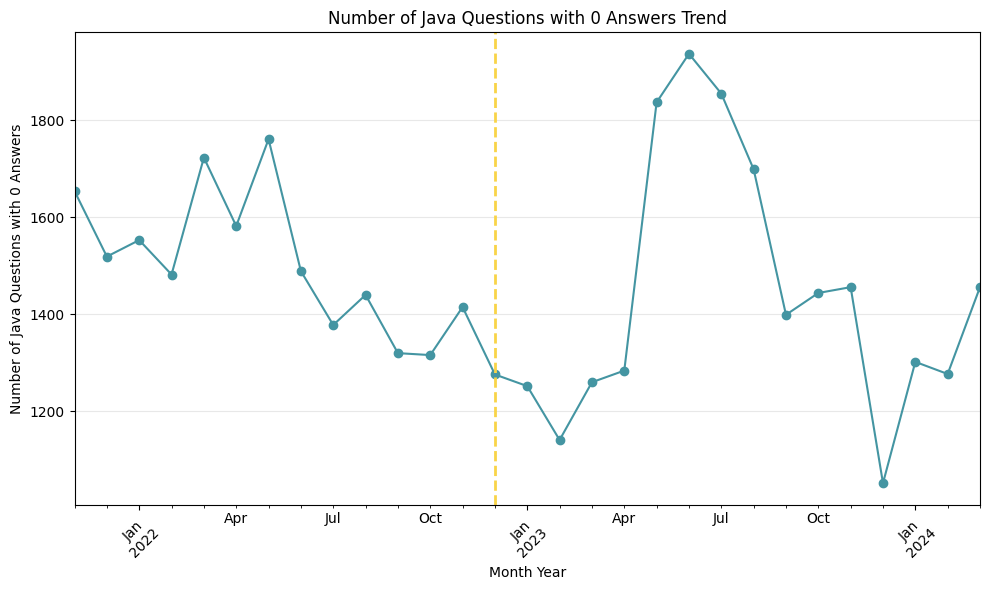

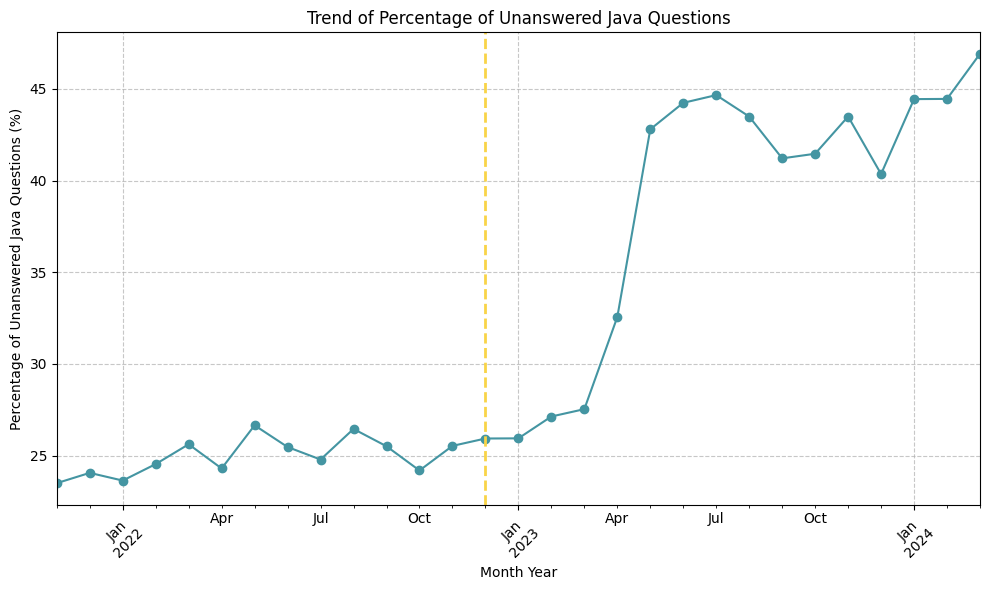

In [60]:
# Define the intervention date for the vertical line
intervention_date = pd.Timestamp('2022-12-01')

# Plotting total Java questions per month
java_question_trend = java_questions.groupby(java_questions['final_date'].dt.to_period('M'))['question_id'].nunique()
plt.figure(figsize=(10, 6))
java_question_trend.plot(kind='line', marker='o', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2)
plt.title('Number of Java Questions Trend')
plt.xlabel('Month Year')
plt.ylabel('Number of Java Questions')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)
plt.tight_layout()
plt.show()

# Calculate the total answers and number of questions per month for java-tagged questions
java_monthly_data = java_questions.groupby(java_questions['final_date'].dt.to_period('M')).agg(
    total_answers=('answer_count', 'sum'),
    num_questions=('question_id', 'count')
)
java_monthly_data['avg_answers_per_question'] = java_monthly_data['total_answers'] / java_monthly_data['num_questions']
plt.figure(figsize=(10, 6))
java_monthly_data['avg_answers_per_question'].plot(kind='line', marker='o', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2)
plt.title('Average Number of Answers per Java Question Trend')
plt.xlabel('Month Year')
plt.ylabel('Average Number of Answers per Java Question')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)
plt.tight_layout()
plt.show()

# Count the number of java questions with zero answers per month
java_zero_answers = java_questions[java_questions['answer_count'] == 0]
java_zero_answer_trend = java_zero_answers.groupby(java_zero_answers['final_date'].dt.to_period('M')).size()
plt.figure(figsize=(10, 6))
java_zero_answer_trend.plot(kind='line', marker='o', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2)
plt.title('Number of Java Questions with 0 Answers Trend')
plt.xlabel('Month Year')
plt.ylabel('Number of Java Questions with 0 Answers')
plt.xticks(rotation=45)
plt.grid(True, which='major', axis='y', color='lightgrey', alpha=0.5)
plt.tight_layout()
plt.show()

# Recalculate total Java questions and unanswered Java questions for accuracy
java_monthly_data = java_questions.groupby(java_questions['final_date'].dt.to_period('M')).agg(
    total_java_questions=('question_id', 'count'),
    unanswered_java_questions=('answer_count', lambda x: (x == 0).sum())
)
java_monthly_data['percentage_unanswered'] = (java_monthly_data['unanswered_java_questions'] / java_monthly_data['total_java_questions']) * 100
plt.figure(figsize=(10, 6))
java_monthly_data['percentage_unanswered'].plot(kind='line', marker='o', color='#4495a2', label='_nolegend_')
plt.axvline(intervention_date, color='#f9d448', linestyle='--', linewidth=2)
plt.title('Trend of Percentage of Unanswered Java Questions')
plt.xlabel('Month Year')
plt.ylabel('Percentage of Unanswered Java Questions (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Causal Analysis - Regression Discontinuity

## Python

Regression discontinuity on Python questions

In [61]:
# python_questions is defined, make a copy to avoid SettingWithCopyWarning
python_questions_copy = python_questions.copy()

# Check if 'final_date' is already a Period, if not convert it
if not isinstance(python_questions_copy['final_date'].dtype, pd.PeriodDtype):
    python_questions_copy['final_date'] = pd.to_datetime(python_questions_copy['final_date']).dt.to_period('M')

# Define the intervention date
intervention_date = pd.Period('2022-12', freq='M')

# Create a DataFrame with counts of questions per month
monthly_counts = python_questions_copy.groupby('final_date').size()

# Filter data to 12 months before and after the intervention
start_period = intervention_date - 12
end_period = intervention_date + 12
monthly_counts = monthly_counts[start_period:end_period]

# Convert period index differences to integers correctly
monthly_counts.index = [(x - intervention_date).n for x in monthly_counts.index]

# Convert to DataFrame for easier manipulation
monthly_counts = monthly_counts.reset_index()
monthly_counts.columns = ['months_from_intervention', 'num_questions']

# Add a dummy variable for post-intervention periods
monthly_counts['post_intervention'] = (monthly_counts['months_from_intervention'] > 0).astype(int)

Fit the model and regression discontinuity

                            OLS Regression Results                            
Dep. Variable:          num_questions   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     231.4
Date:                Tue, 07 May 2024   Prob (F-statistic):           3.05e-16
Time:                        01:10:35   Log-Likelihood:                -202.05
No. Observations:                  25   AIC:                             412.1
Df Residuals:                      21   BIC:                             417.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

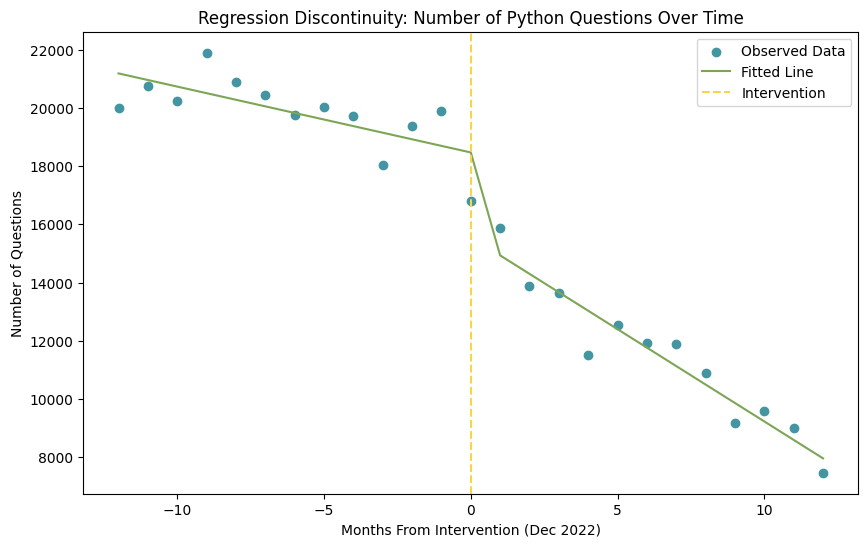

In [62]:
# Fit the regression model
model = ols('num_questions ~ post_intervention * months_from_intervention', data=monthly_counts).fit()

# Summary of the model
print(model.summary())

# Plot
plt.figure(figsize=(10, 6))
# Scatter plot for observed data
plt.scatter(monthly_counts['months_from_intervention'], monthly_counts['num_questions'], color='#4495a2', label='Observed Data')
# Add model predictions
monthly_counts['predictions'] = model.fittedvalues
# Line plot for the regression line
plt.plot(monthly_counts['months_from_intervention'], monthly_counts['predictions'], color='#7ca655', label='Fitted Line')
# Title and labels
plt.title('Regression Discontinuity: Number of Python Questions Over Time')
plt.xlabel('Months From Intervention (Dec 2022)')
plt.ylabel('Number of Questions')
# Vertical line to indicate the intervention point
plt.axvline(x=0, color='#f9d448', linestyle='--', label='Intervention')
# Adding legend to the plot
plt.legend()
# Grid for better readability
plt.grid(False)
# Display the plot
plt.show()

Regression discontinuity on Python average answer per question

                               OLS Regression Results                               
Dep. Variable:     avg_answers_per_question   R-squared:                       0.936
Model:                                  OLS   Adj. R-squared:                  0.927
Method:                       Least Squares   F-statistic:                     103.0
Date:                      Tue, 07 May 2024   Prob (F-statistic):           1.01e-12
Time:                              01:10:35   Log-Likelihood:                 46.428
No. Observations:                        25   AIC:                            -84.86
Df Residuals:                            21   BIC:                            -79.98
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

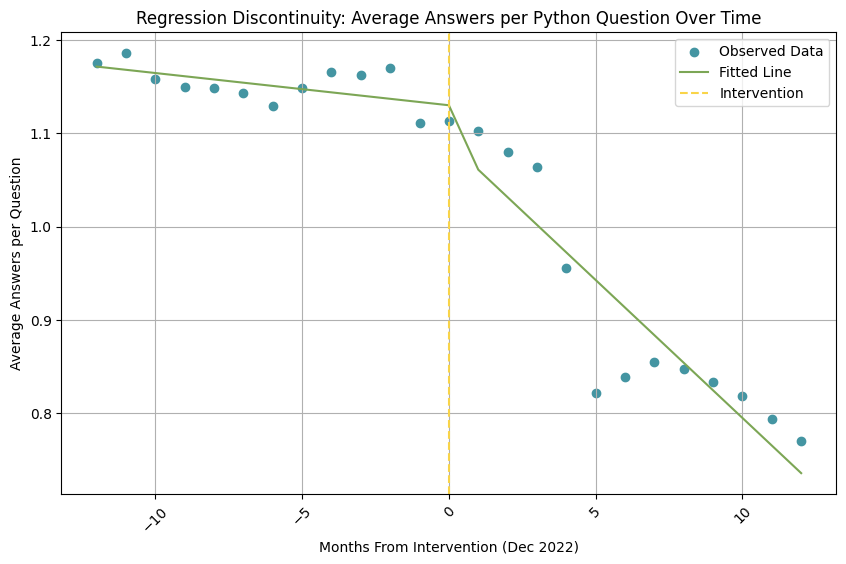

In [63]:
# Copy the DataFrame to avoid SettingWithCopyWarning and ensure it's in the correct format
python_questions_copy = python_questions.copy()
if not isinstance(python_questions_copy['final_date'].dtype, pd.PeriodDtype):
    python_questions_copy['final_date'] = pd.to_datetime(python_questions_copy['final_date']).dt.to_period('M')

# Define the intervention date
intervention_date = pd.Period('2022-12', freq='M')

# Aggregate data to calculate total answers and number of questions per month
monthly_data = python_questions_copy.groupby('final_date').agg(
    total_answers=('answer_count', 'sum'),
    num_questions=('question_id', 'count')
)

# Calculate the average number of answers per question
monthly_data['avg_answers_per_question'] = monthly_data['total_answers'] / monthly_data['num_questions']

# Filter data to 12 months before and after the intervention
start_period = intervention_date - 12
end_period = intervention_date + 12
monthly_data = monthly_data.loc[start_period:end_period]

# Create the time index relative to the intervention
monthly_data.reset_index(inplace=True)
monthly_data['months_from_intervention'] = monthly_data['final_date'].apply(lambda x: (x - intervention_date).n)

# Add a dummy variable for post-intervention periods
monthly_data['post_intervention'] = (monthly_data['months_from_intervention'] > 0).astype(int)

# Fit the regression model
model = ols('avg_answers_per_question ~ post_intervention * months_from_intervention', data=monthly_data).fit()

# Summary of the model
print(model.summary())

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(monthly_data['months_from_intervention'], monthly_data['avg_answers_per_question'], color='#4495a2', label='Observed Data')  # Change point color to #4495a2
monthly_data['predictions'] = model.fittedvalues
plt.plot(monthly_data['months_from_intervention'], monthly_data['predictions'], color='#7ca655', label='Fitted Line')  # Change line color to #7ca655
plt.axvline(x=0, color='#f9d448', linestyle='--', label='Intervention')  # Change intervention line color to #f9d448
plt.title('Regression Discontinuity: Average Answers per Python Question Over Time')
plt.xlabel('Months From Intervention (Dec 2022)')
plt.ylabel('Average Answers per Question')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Java

Regression discontinuity on Java questions

                            OLS Regression Results                            
Dep. Variable:          num_questions   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     100.6
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.27e-12
Time:                        01:10:36   Log-Likelihood:                -177.43
No. Observations:                  25   AIC:                             362.9
Df Residuals:                      21   BIC:                             367.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

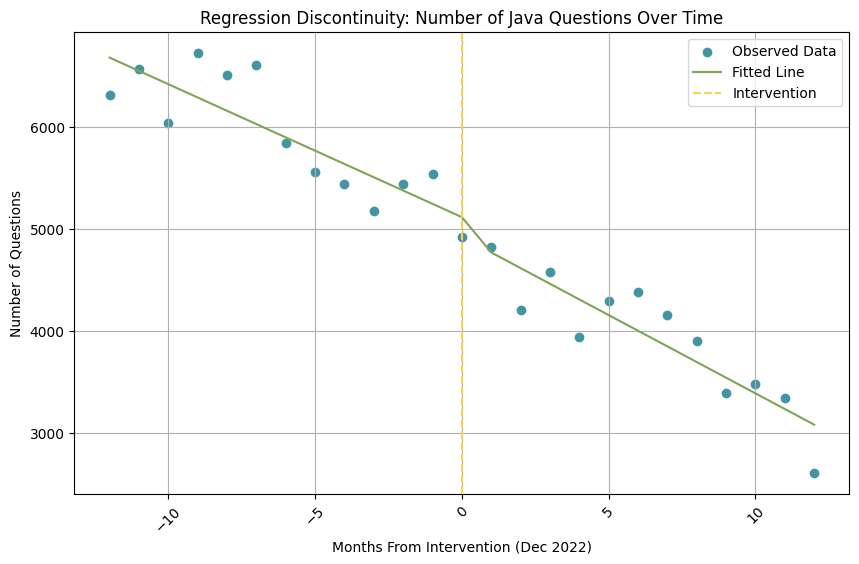

In [64]:
# Copy the DataFrame to avoid SettingWithCopyWarning
java_questions_copy = java_questions.copy()

# Check if 'final_date' is already a Period, if not convert it
if not isinstance(java_questions_copy['final_date'].dtype, pd.PeriodDtype):
    java_questions_copy['final_date'] = pd.to_datetime(java_questions_copy['final_date']).dt.to_period('M')

# Define the intervention date
intervention_date = pd.Period('2022-12', freq='M')

# Create a DataFrame with counts of questions per month
monthly_counts = java_questions_copy.groupby('final_date').size()

# Filter data to 12 months before and after the intervention
start_period = intervention_date - 12
end_period = intervention_date + 12
monthly_counts = monthly_counts[start_period:end_period]

# Convert period index differences to integers correctly
monthly_counts.index = [(x - intervention_date).n for x in monthly_counts.index]

# Convert to DataFrame for easier manipulation
monthly_counts = monthly_counts.reset_index()
monthly_counts.columns = ['months_from_intervention', 'num_questions']

# Add a dummy variable for post-intervention periods
monthly_counts['post_intervention'] = (monthly_counts['months_from_intervention'] > 0).astype(int)

# Fit the regression model
model = ols('num_questions ~ post_intervention * months_from_intervention', data=monthly_counts).fit()

# Summary of the model
print(model.summary())

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(monthly_counts['months_from_intervention'], monthly_counts['num_questions'], color='#4495a2', label='Observed Data')
monthly_counts['predictions'] = model.fittedvalues
plt.plot(monthly_counts['months_from_intervention'], monthly_counts['predictions'], color='#7ca655', label='Fitted Line')
plt.axvline(x=0, color='#f9d448', linestyle='--', label='Intervention')
plt.title('Regression Discontinuity: Number of Java Questions Over Time')
plt.xlabel('Months From Intervention (Dec 2022)')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Regression discontinuity on Java average answer per question

                               OLS Regression Results                               
Dep. Variable:     avg_answers_per_question   R-squared:                       0.889
Model:                                  OLS   Adj. R-squared:                  0.874
Method:                       Least Squares   F-statistic:                     56.33
Date:                      Tue, 07 May 2024   Prob (F-statistic):           3.25e-10
Time:                              01:10:36   Log-Likelihood:                 44.586
No. Observations:                        25   AIC:                            -81.17
Df Residuals:                            21   BIC:                            -76.30
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

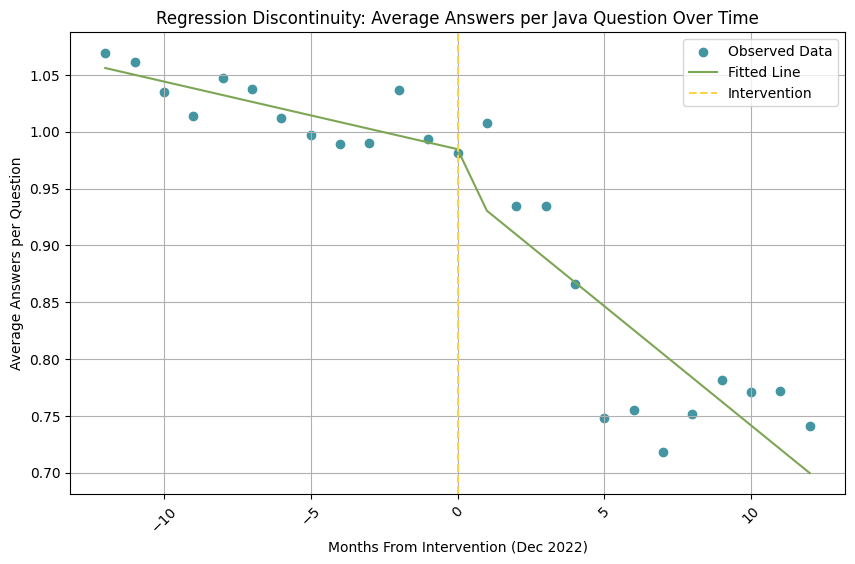

In [65]:
# Copy the DataFrame to avoid SettingWithCopyWarning
java_questions_copy = java_questions.copy()
if not isinstance(java_questions_copy['final_date'].dtype, pd.PeriodDtype):
    java_questions_copy['final_date'] = pd.to_datetime(java_questions_copy['final_date']).dt.to_period('M')

# Define the intervention date
intervention_date = pd.Period('2022-12', freq='M')

# Aggregate data to calculate total answers and number of questions per month
monthly_data = java_questions_copy.groupby('final_date').agg(
    total_answers=('answer_count', 'sum'),
    num_questions=('question_id', 'count')
)

# Calculate the average number of answers per question
monthly_data['avg_answers_per_question'] = monthly_data['total_answers'] / monthly_data['num_questions']

# Filter data to 12 months before and after the intervention
start_period = intervention_date - 12
end_period = intervention_date + 12
monthly_data = monthly_data.loc[start_period:end_period]

# Create the time index relative to the intervention
monthly_data.reset_index(inplace=True)
monthly_data['months_from_intervention'] = monthly_data['final_date'].apply(lambda x: (x - intervention_date).n)

# Add a dummy variable for post-intervention periods
monthly_data['post_intervention'] = (monthly_data['months_from_intervention'] > 0).astype(int)

# Fit the regression model
model = ols('avg_answers_per_question ~ post_intervention * months_from_intervention', data=monthly_data).fit()

# Summary of the model
print(model.summary())

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(monthly_data['months_from_intervention'], monthly_data['avg_answers_per_question'], color='#4495a2', label='Observed Data')  # Change point color to #4495a2
monthly_data['predictions'] = model.fittedvalues
plt.plot(monthly_data['months_from_intervention'], monthly_data['predictions'], color='#7ca655', label='Fitted Line')  # Change line color to #7ca655
plt.axvline(x=0, color='#f9d448', linestyle='--', label='Intervention')  # Change intervention line color to #f9d448
plt.title('Regression Discontinuity: Average Answers per Java Question Over Time')
plt.xlabel('Months From Intervention (Dec 2022)')
plt.ylabel('Average Answers per Question')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Similarity of questions before and after Analysis using the Cosine Similarity

* Removal of stop words and punctuations.
* td-idf (term frequency - inverse document frequency) for  measure of importance of a word to a document/title.
* Dimension Reduction using NMF
* Cosine Similarity is done in two-folds.
  1.   Similarity check on questions posted before chatgpt alone to see how similar the questions are for basic intuitive idea
  2.   Next, checked the similarity of questions posted between before and after questions



Download the stop words

In [66]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Function for converting text to lower case, removal of punctuations and stop words.

In [67]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = ''.join(char for char in text if char not in string.punctuation)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Define the intervention date
intervention_date = pd.Timestamp('2022-12-01')

Due to low computational power locally, considered the data for 6 months before and after the launch of ChatGPT and also considered 100 random samples before and after due to low computational power.

## Python

Python questions between before and after the launch of ChatGPT

In [68]:
# Narrow down the date range to 6 months before and after the intervention
before_intervention = python_questions.loc[
    (python_questions['final_date'] < intervention_date) &
    (python_questions['final_date'] >= intervention_date - pd.DateOffset(months=6))
].copy()
after_intervention = python_questions.loc[
    (python_questions['final_date'] >= intervention_date) &
    (python_questions['final_date'] <= intervention_date + pd.DateOffset(months=6))
].copy()

# Apply sampling if still needed due to large dataset size
sample_size = 100  # Adjust sample size based on memory and performance needs
before_intervention = before_intervention.sample(n=sample_size, random_state=1)
after_intervention = after_intervention.sample(n=sample_size, random_state=1)

# Preprocess text data
before_intervention['cleaned_title'] = before_intervention['title'].apply(clean_text)
after_intervention['cleaned_title'] = after_intervention['title'].apply(clean_text)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Reducing features
tfidf_matrix = vectorizer.fit_transform(before_intervention['cleaned_title'].tolist() + after_intervention['cleaned_title'].tolist())

# Reduce dimensionality further
svd = TruncatedSVD(n_components=50)  # More aggressive dimensionality reduction
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Split the reduced TF-IDF matrix
split_index = len(before_intervention)
before_tfidf = tfidf_reduced[:split_index]
after_tfidf = tfidf_reduced[split_index:]

# Compute cosine similarity
cosine_sim = cosine_similarity(before_tfidf, after_tfidf)

# Compute the average cosine similarity
average_similarity = np.mean(cosine_sim, axis=1)
print("Average cosine similarity between questions before and after intervention:", np.mean(average_similarity))


Average cosine similarity between questions before and after intervention: 0.031601941395756755


Create a table of similarity with top 10 similarities

In [69]:
# Create a DataFrame from the cosine similarity matrix
titles_before = before_intervention['title'].tolist()
titles_after = after_intervention['title'].tolist()
similarity_df = pd.DataFrame(cosine_sim, index=titles_before, columns=titles_after)

# Flatten the DataFrame and reset index to turn it into a long format DataFrame
similarity_long_df = similarity_df.stack().reset_index()
similarity_long_df.columns = ['Question Before', 'Question After', 'Cosine Similarity']

# Sort by cosine similarity for both highest and lowest
top_similarities = similarity_long_df.sort_values(by='Cosine Similarity', ascending=False).head(10)
lowest_similarities = similarity_long_df.sort_values(by='Cosine Similarity', ascending=True).head(10)

# Display the DataFrames
print("Top 10 High Similarity Pairs:")
print(top_similarities)
print("\nTop 10 Low Similarity Pairs:")
print(lowest_similarities)


Top 10 High Similarity Pairs:
                                        Question Before  \
8684                   user crate oval shape in tkinter   
2035  How to define a Content Id on an attachment us...   
2089  How to define a Content Id on an attachment us...   
7189  ndarray is not C-contiguous using scikit-learn...   
3966            Annotation with Line plot in Matplotlib   
7238                 Translation from Mathcad to Python   
7979                       Slice multidimensional array   
5367               Number Guessing game using SimpleGUI   
7135  ndarray is not C-contiguous using scikit-learn...   
4772   How to load yaml string placeholders for python?   

                                         Question After  Cosine Similarity  
8684                 tkinter scrollable listbox refresh           0.989545  
2035  Rasterio reproject using from_gcps moves raste...           0.966843  
2089  How to broadcast using asyncio&#39;s datagram ...           0.965845  
7189  How to

* Cosine similarity +1 implies completely similar and -1 implies compltely dissimilar.
* Created a buckets of similarity score and percentage of questions fall under each bucket.

Number of question pairs in each similarity range:
Similarity Range
-1 to -0.7         0
-0.7 to -0.5       1
-0.5 to -0.2      73
-0.2 to 0       4661
0 to 0.2        4501
0.2 to 0.5       589
0.5 to 0.7       121
0.7 to 1          54
Name: count, dtype: int64


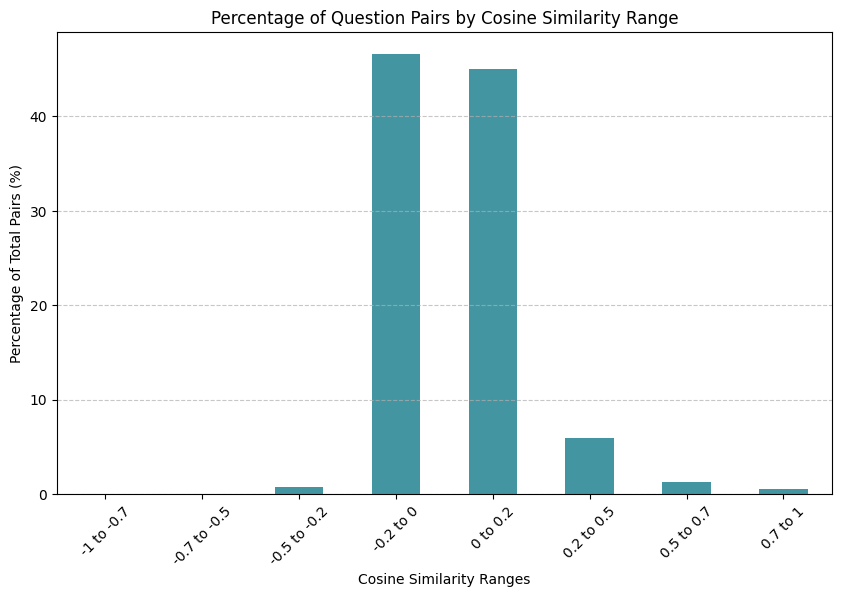

In [70]:
# Define the bins for cosine similarity scores
bins = [-1, -0.7, -0.5, -0.2, 0, 0.2, 0.5, 0.7, 1]

# Use pd.cut to categorize the similarity scores into bins
similarity_long_df['Similarity Range'] = pd.cut(similarity_long_df['Cosine Similarity'], bins=bins, labels=["-1 to -0.7", "-0.7 to -0.5", "-0.5 to -0.2", "-0.2 to 0", "0 to 0.2", "0.2 to 0.5", "0.5 to 0.7", "0.7 to 1"])

# Count the number of entries in each bin
similarity_counts = similarity_long_df['Similarity Range'].value_counts().sort_index()

# Display the counts
print("Number of question pairs in each similarity range:")
print(similarity_counts)

# Convert counts to percentages
total_counts = similarity_counts.sum()
similarity_percentages = (similarity_counts / total_counts) * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
similarity_percentages.plot(kind='bar', color='#4495a2')  # Use specified color for the bars
plt.title('Percentage of Question Pairs by Cosine Similarity Range')
plt.xlabel('Cosine Similarity Ranges')
plt.ylabel('Percentage of Total Pairs (%)')
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for better reference
plt.show()

Python questions among before the launch of ChatGPT

Number of question pairs in each similarity range:
Similarity Range
-1 to -0.7         0
-0.7 to -0.5       0
-0.5 to -0.2       4
-0.2 to 0       4732
0 to 0.2        4606
0.2 to 0.5       448
0.5 to 0.7        82
0.7 to 1          28
Name: count, dtype: int64


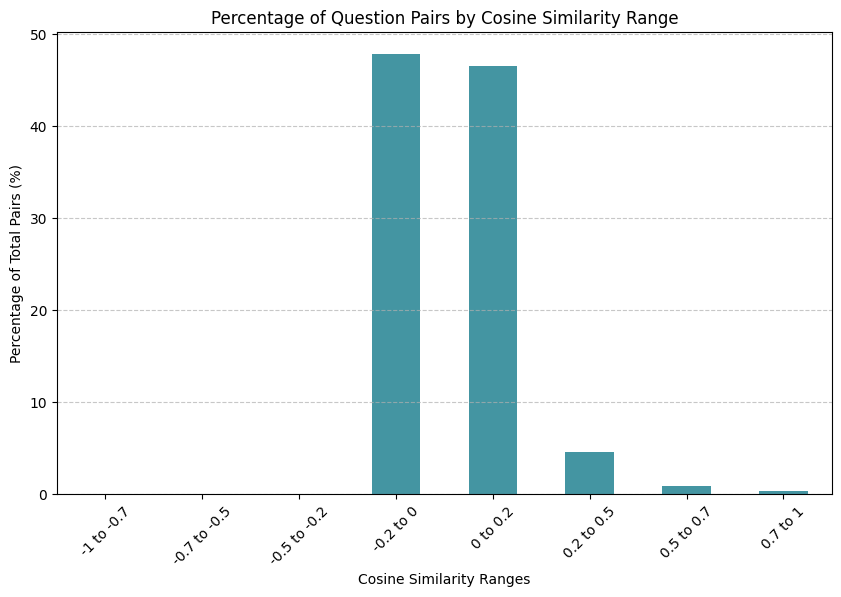

In [71]:
# Vectorize text using TF-IDF
vectorizer_before = TfidfVectorizer(max_features=500)
before_tfidf = vectorizer_before.fit_transform(before_intervention['cleaned_title'])

# Apply SVD to reduce dimensionality
svd = TruncatedSVD(n_components=50)
before_tfidf_reduced = svd.fit_transform(before_tfidf)

# Compute cosine similarity within the 'before' questions using the reduced data
cosine_sim_before = cosine_similarity(before_tfidf_reduced)

# Since the similarity of a question with itself is not useful, we set the diagonal to NaN
np.fill_diagonal(cosine_sim_before, np.nan)

# Flatten the matrix and remove NaN values
similarity_values_before = cosine_sim_before.flatten()
similarity_values_before = similarity_values_before[~np.isnan(similarity_values_before)]

# Create a DataFrame from the flattened similarity values
similarity_df_before = pd.DataFrame(similarity_values_before, columns=['Cosine Similarity'])

# Define the bins and labels
bins = [-1, -0.7, -0.5, -0.2, 0, 0.2, 0.5, 0.7, 1]
labels = ["-1 to -0.7", "-0.7 to -0.5", "-0.5 to -0.2", "-0.2 to 0", "0 to 0.2", "0.2 to 0.5", "0.5 to 0.7", "0.7 to 1"]

# Bin the data
similarity_df_before['Similarity Range'] = pd.cut(similarity_df_before['Cosine Similarity'], bins=bins, labels=labels)

# Count the number of entries in each bin
similarity_counts_before = similarity_df_before['Similarity Range'].value_counts().sort_index()

# Display the counts
print("Number of question pairs in each similarity range:")
print(similarity_counts_before)

# Convert counts to percentages
total_counts_before = similarity_counts_before.sum()
similarity_percentages_before = (similarity_counts_before / total_counts_before) * 100

# Create a bar chart
# Create a bar chart
plt.figure(figsize=(10, 6))
similarity_percentages_before.plot(kind='bar', color='#4495a2')
plt.title('Percentage of Question Pairs by Cosine Similarity Range')
plt.xlabel('Cosine Similarity Ranges')
plt.ylabel('Percentage of Total Pairs (%)')
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for better reference
plt.show()

Java questions between before and after the launch of ChatGPT

Average cosine similarity between questions before and after intervention: 0.03092078311052764
Top 10 High Similarity Pairs:
                                        Question Before  \
5232  Retrying webclient post with modification of t...   
3610  Why does my activity calls onCreate if opened ...   
8400                        MyBatis query in a for loop   
3807             Spring Boot : Disable Quartz Scheduler   
1212                AES Encryption From Java to Node.js   
9521  How to load resources from classpath matching ...   
5125                            Updating a child entity   
1919  Java - Calculating durations with a factorized...   
6811  why does maven don&#39;t download jar files fo...   
3169  Angular excel file upload throws NotOfficeXmlF...   

                                         Question After  Cosine Similarity  
5232        POST request works, DELETE request does not           0.996497  
3610   Changing the picture when calling a new activity           0.969

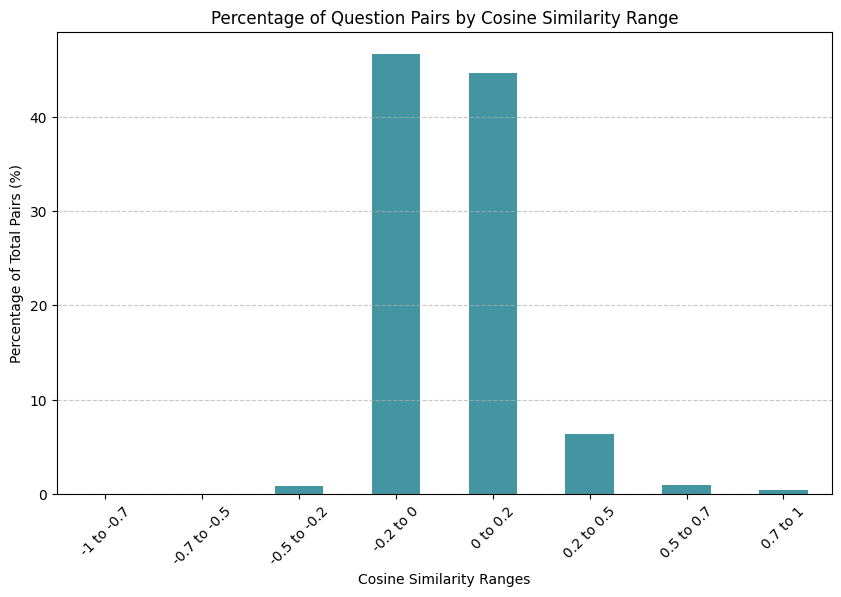

In [72]:
# Narrow down the date range to 6 months before and after the intervention
before_intervention = java_questions.loc[
    (java_questions['final_date'] < intervention_date) &
    (java_questions['final_date'] >= intervention_date - pd.DateOffset(months=6))
].copy()
after_intervention = java_questions.loc[
    (java_questions['final_date'] >= intervention_date) &
    (java_questions['final_date'] <= intervention_date + pd.DateOffset(months=6))
].copy()

# Apply sampling if still needed due to large dataset size
sample_size = 100  # Adjust sample size based on memory and performance needs
before_intervention = before_intervention.sample(n=sample_size, random_state=1)
after_intervention = after_intervention.sample(n=sample_size, random_state=1)

# Preprocess text data
before_intervention['cleaned_title'] = before_intervention['title'].apply(clean_text)
after_intervention['cleaned_title'] = after_intervention['title'].apply(clean_text)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Reducing features
tfidf_matrix = vectorizer.fit_transform(before_intervention['cleaned_title'].tolist() + after_intervention['cleaned_title'].tolist())

# Reduce dimensionality further
svd = TruncatedSVD(n_components=50)  # More aggressive dimensionality reduction
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Split the reduced TF-IDF matrix
split_index = len(before_intervention)
before_tfidf = tfidf_reduced[:split_index]
after_tfidf = tfidf_reduced[split_index:]

# Compute cosine similarity
cosine_sim = cosine_similarity(before_tfidf, after_tfidf)

# Compute the average cosine similarity
average_similarity = np.mean(cosine_sim, axis=1)
print("Average cosine similarity between questions before and after intervention:", np.mean(average_similarity))


# Create a DataFrame from the cosine similarity matrix
titles_before = before_intervention['title'].tolist()
titles_after = after_intervention['title'].tolist()
similarity_df = pd.DataFrame(cosine_sim, index=titles_before, columns=titles_after)

# Flatten the DataFrame and reset index to turn it into a long format DataFrame
similarity_long_df = similarity_df.stack().reset_index()
similarity_long_df.columns = ['Question Before', 'Question After', 'Cosine Similarity']

# Sort by cosine similarity for both highest and lowest
top_similarities = similarity_long_df.sort_values(by='Cosine Similarity', ascending=False).head(10)
lowest_similarities = similarity_long_df.sort_values(by='Cosine Similarity', ascending=True).head(10)

# Display the DataFrames
print("Top 10 High Similarity Pairs:")
print(top_similarities)
print("\nTop 10 Low Similarity Pairs:")
print(lowest_similarities)

# Define the bins for cosine similarity scores
bins = [-1, -0.7, -0.5, -0.2, 0, 0.2, 0.5, 0.7, 1]

# Use pd.cut to categorize the similarity scores into bins
similarity_long_df['Similarity Range'] = pd.cut(similarity_long_df['Cosine Similarity'], bins=bins, labels=["-1 to -0.7", "-0.7 to -0.5", "-0.5 to -0.2", "-0.2 to 0", "0 to 0.2", "0.2 to 0.5", "0.5 to 0.7", "0.7 to 1"])

# Count the number of entries in each bin
similarity_counts = similarity_long_df['Similarity Range'].value_counts().sort_index()

# Display the counts
print("Number of question pairs in each similarity range:")
print(similarity_counts)

# Convert counts to percentages
total_counts = similarity_counts.sum()
similarity_percentages = (similarity_counts / total_counts) * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
similarity_percentages.plot(kind='bar', color='#4495a2')
plt.title('Percentage of Question Pairs by Cosine Similarity Range')
plt.xlabel('Cosine Similarity Ranges')
plt.ylabel('Percentage of Total Pairs (%)')
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for better reference
plt.show()

Java questions among before the launch of ChatGPT

Number of question pairs in each similarity range:
Similarity Range
-1 to -0.7         0
-0.7 to -0.5       0
-0.5 to -0.2      20
-0.2 to 0       4758
0 to 0.2        4546
0.2 to 0.5       468
0.5 to 0.7        88
0.7 to 1          20
Name: count, dtype: int64


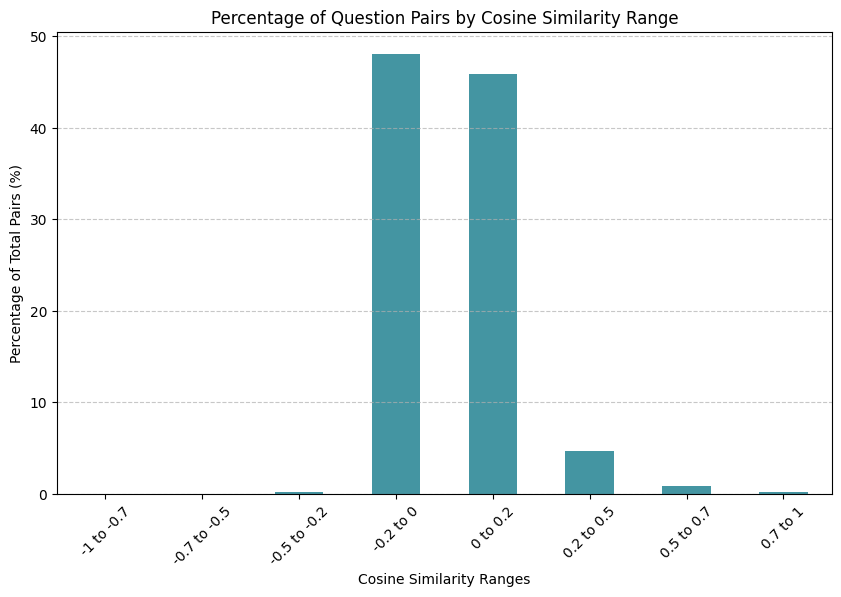

In [73]:
# Vectorize text using TF-IDF
vectorizer_before = TfidfVectorizer(max_features=500)
before_tfidf = vectorizer_before.fit_transform(before_intervention['cleaned_title'])

# Apply SVD to reduce dimensionality
svd = TruncatedSVD(n_components=50)
before_tfidf_reduced = svd.fit_transform(before_tfidf)

# Compute cosine similarity within the 'before' questions using the reduced data
cosine_sim_before = cosine_similarity(before_tfidf_reduced)

# Since the similarity of a question with itself is not useful, we set the diagonal to NaN
np.fill_diagonal(cosine_sim_before, np.nan)

# Flatten the matrix and remove NaN values
similarity_values_before = cosine_sim_before.flatten()
similarity_values_before = similarity_values_before[~np.isnan(similarity_values_before)]

# Create a DataFrame from the flattened similarity values
similarity_df_before = pd.DataFrame(similarity_values_before, columns=['Cosine Similarity'])

# Define the bins and labels
bins = [-1, -0.7, -0.5, -0.2, 0, 0.2, 0.5, 0.7, 1]
labels = ["-1 to -0.7", "-0.7 to -0.5", "-0.5 to -0.2", "-0.2 to 0", "0 to 0.2", "0.2 to 0.5", "0.5 to 0.7", "0.7 to 1"]

# Bin the data
similarity_df_before['Similarity Range'] = pd.cut(similarity_df_before['Cosine Similarity'], bins=bins, labels=labels)

# Count the number of entries in each bin
similarity_counts_before = similarity_df_before['Similarity Range'].value_counts().sort_index()

# Display the counts
print("Number of question pairs in each similarity range:")
print(similarity_counts_before)

# Convert counts to percentages
total_counts_before = similarity_counts_before.sum()
similarity_percentages_before = (similarity_counts_before / total_counts_before) * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
similarity_percentages_before.plot(kind='bar', color='#4495a2')
plt.title('Percentage of Question Pairs by Cosine Similarity Range')
plt.xlabel('Cosine Similarity Ranges')
plt.ylabel('Percentage of Total Pairs (%)')
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for better reference
plt.show()